The purpose of this notebook is to explore our scraped tweets with query of the hashtag "#COVID19". In this we are going to first preprocess the tweets, perform some visualisations and later on investigate if there is a correlation between COVID19 and scarcity and if so, try to quantify it. An issue with this very model is that we require a benchmark to compare against, otherwise the values we report are effectively useless. Maybe a better model would be to query the hashtag "#Hunger" or "#Poverty" and see how many associations there are with coronavirus. Again, past data would come in handly. Perhaps a Premium Twitter Developer account may help and we can form a partnership of some kind with the right people to aid in this quest for analysis of tweets. More visualiastion here than NLP.

<br>

Some time later: Preprocessing took too long, reducing amount of lines to just 1000. Query hashtag "#hunger" and see how many are related to '#covid19'. See if we can apply BERT/ALBERT to predict if hashtag also contains #Covid also.


Author: Steven Vuong<br>
Last Edited: 17-05-2020

In [1]:
import pandas as pd

csv_savepath = "../../data/tweets.csv"
tweets_df = pd.read_csv(csv_savepath) # Of query "#COVID19"

In [2]:
print(f"Num of rows: {len(tweets_df)}")
tweets_df.head()

Num of rows: 1000


,tweet_creation_date,tweet_text,tweet_retweet_count,tweet_favourite_count,tweet_hashtags,user_follow_count,user_created_at,user_verified
0,2020-05-17 14:36:25,RT @jdfarag: The #sun has entered a ‘lockdown’...,111,0,"['sun', 'famine', 'endtimes', 'BibleProphecy',...",32,2018-09-17 22:49:14,False
1,2020-05-17 14:27:49,Kenya's pastoralists face #hunger and conflict...,0,0,"['hunger', 'Kenya', 'Locusts']",974,2016-06-28 19:39:16,False
2,2020-05-17 14:21:52,RT @drvandanashiva: #EssentialCommoditiesAct w...,36,0,"['EssentialCommoditiesAct', 'SeedPriceControlO...",27,2010-05-29 12:41:00,False
3,2020-05-17 14:15:25,But when a man who could literally #hunger in ...,0,0,['hunger'],836,2009-03-27 01:52:54,False
4,2020-05-17 14:14:25,"RT @PresidentIRL: In April this year, the Pres...",7,0,['hunger'],375,2014-07-04 16:19:51,False


We will try get some ideas for preprocessing from other notebooks/kernels.

-  Idea: Try to predict if tweet contains hashtag "#Hunger" or related. Can use tweet text and other data to try and predict then ensemble. Brilliant template for model training: https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle
-  Preprocessing: https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
-  Visualisation: https://www.kaggle.com/duttadebadri/detailed-nlp-project-prediction-visualization
    - Histogram/barplots for frequency
    - Wordcloud (Hoping to do post processing)
    - Word correlation map
    
Also to consider: unigrams/bigrams/trigrams


In [3]:
from text_preprocessor import apply_hashtag_preprocessing, apply_tweet_text_preprocessing
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/steven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/steven/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/steven/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Process all tweet texts (really slow) -> Todo: Parallelise
processed_tweet_texts = [apply_tweet_text_preprocessing(tweet_text) for tweet_text in tqdm(tweets_df['tweet_text'].values)]

# make column for processed tweets and save
tweets_df['processed_tweets'] = processed_tweet_texts

In [ ]:
tweets_df.to_pickle('"../../data/tweets_processed.pkl"')

In [22]:
# Make a list of list of all the hashtags (keep order)
tweet_hashtags_list = [th.lstrip("[").rstrip("]") for th in tweets_df['tweet_hashtags'] if len(th)!=2]

# make a list of all hashtags (altogether)
tweet_hashtags = []
[tweet_hashtags.extend(thl.split()) for thl in tweet_hashtags_list]

# Process all hashtags
processed_hashtags = [apply_hashtag_preprocessing(hashtag) for hashtag in tweet_hashtags]

print(processed_hashtags[:5])

['sun', 'famine', 'endtimes', 'bibleprophecy', 'revelation']


529 Unique Hashtags


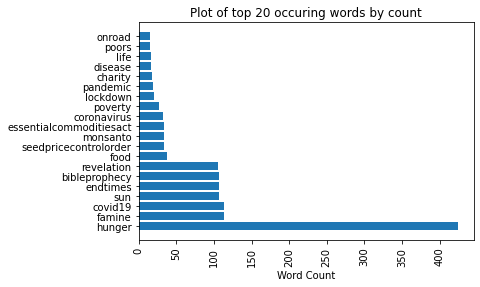

In [74]:
# Visualise counts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

unique_hashtags, unique_hashtag_counts = np.unique(processed_hashtags, return_counts=True)

print(f"{len(unique_hashtags)} Unique Hashtags")

plot_limit = 20
unique_hashtags = [x for _,x in sorted(zip(unique_hashtag_counts,unique_hashtags))][::-1]
unique_hashtag_counts = sorted(unique_hashtag_counts)[::-1]

unique_hashtags = unique_hashtags[:plot_limit]
unique_hashtag_counts = unique_hashtag_counts[:plot_limit]

plt.barh(unique_hashtags, unique_hashtag_counts)
plt.xticks(rotation=90)
plt.xlabel("Word Count")
plt.title(f"Plot of top {plot_limit} occuring words by count")
plt.show()

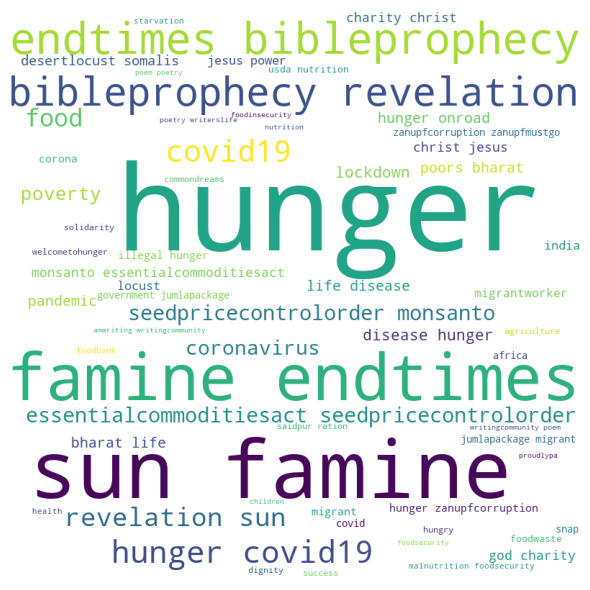

In [30]:
# Create wordcloud to visualise hashtags
# Ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS

hashtag_string = (" ").join(processed_hashtags)

wordcloud = WordCloud(
    width = 800, 
    height = 800, 
    background_color ='white', 
    stopwords = set(STOPWORDS), 
    min_font_size = 10).generate(hashtag_string) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the wordcloud above, we see (obviously) 'hunger' is the most dominant word, as it is our query. We want to determine if covid is a related hashtag. So will have to include synonyms and mentions of covid, these include (from above):
-  covid19
-  coronavirus
-  virus
-  corona
-  covid
-  pandemic

These other interpretations are what we will deal with, turning this into a supervised learning task. The next step is to create our labels, classsifyng as 1 if 'corona' is mentioned along 'hunger' as hashtags and 0 otherwise.

In [76]:
# Check if related words in synonyms
covid_related_synonyms = ['covid19', 'covid', 'corona', 'virus', 'pandemic', 'coronavirus']
tweet_hashtags_list[:5]

["'sun', 'famine', 'endtimes', 'BibleProphecy', 'revelation'",
 "'hunger', 'Kenya', 'Locusts'",
 "'EssentialCommoditiesAct', 'SeedPriceControlOrder', 'Monsanto'",
 "'hunger'",
 "'hunger'"]

In [ ]:
# TODO:
# Add labels to hashtags, whether they contain #hunger or not. 1 or 0. Turn to a supervised
# learning task.

In [50]:
# TODO: Remove most frequent words and most rare words from text